# Sprint 2

This notebook was created by Lennart Onghena, Roel Moeyersoons and Tim De Smet.

This project is a collaboration with ML6. They are launching a product that automates parts of big email inboxes.

During `sprint 1` we created a classifier that for the message of the customers based on the product.

During `sprint 2` we attempt to do the same using clustering by unsupervised learning instead of supervised classification.

In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import re
import string
import nltk

from nltk.corpus import stopwords
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples

from sklearn.cluster import DBSCAN

# 1. EDA

All EDA steps were performed during `sprint 1`.

# 2. Preprocessing


In order to address the problems of the data, we prepared our data. For instance, we created our own product categories. We did this because we found the original Product categories to overlap. We generalized these products because we felt that, for example, all loan related complaints should be handled in a similar manner. Adding to that we balanced the dataset as well. 

When working with text however, additional steps are required.


## 2.1. Read

In [4]:
complaints = pd.read_csv('complaints-2020-01-22_08_24.csv')

## 2.2. Simplify

The following code uses a dictionary to map the original Product columns to the new ones. Using this object one could easily expand/modify the mapping when the data changes overtime.

In [6]:
# simplifying dataset
simp_map = {
    'Debt collection' : 'F', 
    'Payday loan' : 'B', 
    'Mortgage' : 'A', 
    'Bank account or service' : 'E', 
    'Consumer Loan' : 'B', 
    'Other financial service' : 'E', 
    'Vehicle loan or lease' : 'B',
    'Payday loan, title loan, or personal loan' : 'B', 
    'Money transfers' : 'E', 
    'Student loan' : 'B', 
    'Virtual currency': 'E', 
    'Credit reporting, credit repair services, or other personal consumer reports' : 'D', 
    'Credit card' : 'C', 
    'Checking or savings account' : 'E', 
    'Prepaid card' : 'C', 
    'Money transfer, virtual currency, or money service' : 'E', 
    'Credit reporting': 'D', 
    'Credit card or prepaid card' : 'C'}

featureSet = complaints[['Product', 'Consumer complaint narrative']].copy()
featureSet['TARGET'] = featureSet['Product'].map(simp_map)

## 2.3. Balancing

Learning from the EDA phase we clearly noticed that the dataset is imbalanced.
This could cause the model to collapse to the trivial solution of always returning the same prediction. We will resolve this by subsampling in order to flatten the distribution. First let's replace every category by a subsample of that category, limited to 50.000 elements.


In [8]:
for c in ['A', 'B', 'C', 'D', 'E', 'F']:
    if featureSet[featureSet['TARGET'] == c].shape[0] > 50000:
        featureSet = pd.concat(objs=[featureSet[featureSet['TARGET'] == c].sample(n=50000), featureSet[featureSet['TARGET'] != c]])

## 2.4. Sampling

Let's now take a sample from this set that shall be used during the project. The size of the subsample is very important. Too little and your model might be overtuned to some texts, while being undertuned to others. 

The bigger the subsample the more accurate your model will be for the whole dataset. However, in order to not overburden our CPU's, we limit it during the project to 10000. 

A fixed seed is also added so that the same sample is produced every time. We do this in order to keep consistency when running hte notebook several times over and over but it's not stictly needed. Needless to say this can lead to exploits where the model performs very well for this one sample. This is not our intention, the only reason the seed given below is used is because it gives an equalish amount of rows for every target. 

In [10]:
data = featureSet.sample(10000,random_state=7844569)

## 2.5. Text cleaning

We learned from `sprint 1` that cleaning the text is very important. We only applied this in the final phases of `sprint 1`. However, we decided to learn from our mistakes and do this right away during this sprint.
We can clearly see the text contains special characters, numbers, anonymized data, html, etc...
This needed to be dealt with.

In [12]:
pd.set_option('max_colwidth', None)
data[['Product','Consumer complaint narrative']].head()

,Product,Consumer complaint narrative
155108,Credit card or prepaid card,"I HAD NOTICED A CHARGE ON MY CAPITAL ONE ACCOUNT OF XXXX IN XX/XX/XXXX. CONTACTED THE COMPANY AND THEY HAD TAKEN THE CHARGE AWAY. I HAD FAXED PROOF TO THEM THAT THEY CHARGE IS DIFFENTLY FRAUD. I HAD FAXED THEM A COPY OF THE COMPANY THE CHARGE WAS FROM. \nCAPITAL ONE HAD PUT THE CHARGE BACK ON MY ACCOUNT ON XX/XX/XXXX. I HAD CALLED THEM AND THEY REFUSE TO TAKE THE CHARGE OFF. I HAD REFAXED THEM THE PROOF ON XX/XX/XXXX. WITH A LETTER. I HAD CALLED THEM ON XX/XX/XXXX. AGAIN, THEY WILL NOT TAKE OFF THE CHARGE BECAUSE THEY SAID THAT IT IS MY CHARGE EVEN THOUGH I HAD FAXED THEM PROOF TWICE THAT IT IS NOT MINE. I was contacted to XXXX which is my fraud agent and she was not available. I was unable to leave a message due to her mailbox was full."
301863,Debt collection,"D. Scott Carruthers have called, harrassing all my family members, daily, multiple times a day. I do not know what the debt is, I have never received anything via US Mail verifying said debt."
417937,"Credit reporting, credit repair services, or other personal consumer reports",The lien was removed and its still showing just for this agency. I am having trouble with them removing inaccurate information of my report even the ones I have advised do not belong to me they were removed from my other credit reports except this one. It seems I have to fight for them to remove things which isn't right. I disputed directly through their website and still no response
320576,"Money transfer, virtual currency, or money service","I did a wire transfer to Coinbase.com of XXXX to invest in cryptocurrency.\n\nI received a message on their website regarding the transfer and that it will be delayed and processed\n\nwithin 24 hours. It 's been 48+ hours now and nothing. I\n've been on hold on their phone customer support for 1 hour, TWICE in a day. I 'm not the only one experiencing issues like mine. People have even been locked out and accounts r\nemoved with way more money than me, with no reasons given."
381287,Student loan,"1. Mohela is not following the agreement I signed upon gaining my student loans since inception ... The INTEREST ACCRUAL since Mohela took over the loan is incorrect. It was only supposed to accrue interest until it hit the 10 % mark as per my signed agreement, ( which occurred right before Mohela took over from XXXX ) The interest capitalized on my account is now is WAY over. It should have never gone over XXXX and is now {$210000.00}. \n\n2. MOHELA appears to have been improperly tracking and applying your student loan payments- the corrections made have not corrected the balance. As an example, I was charged an extra charge in 2012 for a leap year day that did not exist since they compound interest daily and charged me 366 days at the 365 day rate. I overpaid by roughly {$20.00}, which is then continuously compounded through the life of the loan. More importantly, this continues to show that they are not tracking the loan. \n\n3. I would like to know the status of my forgiveness date and how many eligible payments I have made to qualify me for the XXXX program as well as full paperwork on the exact terms of this forgiveness program. \n\n4. Is there anyway I can move to working with another program as I do not trust Mohela nor do I believe they are doing a correct/efficient job for the Government nor myself."


We created a function filtering out the following unwanted things:
- html
- anonymized data
- numbers
- uppercase
- stopwords

In [14]:
stopWords = stopWords = set(stopwords.words('english'))

def preprocessing(text):
    text = BeautifulSoup(text, "html.parser").text
    translator = str.maketrans('', '', string.punctuation) 
    text = text.translate(translator).lower()
    text = re.sub(r'(x)\1+', '', text)
    text = re.sub(r'[0-9]', r' ', text)
    tokens = []
    for word in text.split():
        if word not in stopWords:
            tokens.append(word)
    return " ".join(tokens)

In [16]:
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(preprocessing)

After applying the function to the whole column, we can see the results are as expected.

In [18]:
data[['Product','Consumer complaint narrative']].head()

,Product,Consumer complaint narrative
155108,Credit card or prepaid card,noticed charge capital one account contacted company taken charge away faxed proof charge diffently fraud faxed copy company charge capital one put charge back account called refuse take charge refaxed proof letter called take charge said charge even though faxed proof twice mine contacted fraud agent available unable leave message due mailbox full
301863,Debt collection,scott carruthers called harrassing family members daily multiple times day know debt never received anything via us mail verifying said debt
417937,"Credit reporting, credit repair services, or other personal consumer reports",lien removed still showing agency trouble removing inaccurate information report even ones advised belong removed credit reports except one seems fight remove things isnt right disputed directly website still response
320576,"Money transfer, virtual currency, or money service",wire transfer coinbasecom invest cryptocurrency received message website regarding transfer delayed processed within hours hours nothing hold phone customer support hour twice day one experiencing issues like mine people even locked accounts r emoved way money reasons given
381287,Student loan,mohela following agreement signed upon gaining student loans since inception interest accrual since mohela took loan incorrect supposed accrue interest hit mark per signed agreement occurred right mohela took interest capitalized account way never gone mohela appears improperly tracking applying student loan payments corrections made corrected balance example charged extra charge leap year day exist since compound interest daily charged days day rate overpaid roughly continuously compounded life loan importantly continues show tracking loan would like know status forgiveness date many eligible payments made qualify program well full paperwork exact terms forgiveness program anyway move working another program trust mohela believe correctefficient job government


## 2.6. Feature Extraction

In order for the computer to understand the customers complaints we needed to use Natural Language Processing techniques. We need to extract features from the messages.

We chose TF-IDF for its normalization features instead of using a simple bag of words. We remembered: "A word that occurs often in a certain document but does not occur often in other documents is probably an important word for this document." This seemed very useful in our case since mails generally follow a fixed pattern and use rather similar vocabulary.

### TF-IDF

In [20]:
%%script false --no-raise-error
tfidf = TfidfVectorizer(
    min_df = 0.3,
    max_df = 0.7,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(data['Consumer complaint narrative'])
transformed = tfidf.transform(data['Consumer complaint narrative'])

Couldn't find program: 'false'


### Doc2Vec

In [22]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(row.split() for row in data['Consumer complaint narrative'])]
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [24]:
transformed = []
for doc in documents:
    transformed.append(model.infer_vector(doc.words, epochs=model.epochs))

In [26]:
transformed = np.asarray(transformed)

## 2.7. Dimensionality Reduction

### Truncated SVD

We learned about TSVD in the previous sprint and decided to try it again.

In [28]:
%%script false --no-raise-error
svd = TruncatedSVD(n_components=2)
reduced = svd.fit_transform(transformed)
print(reduced.shape)

Couldn't find program: 'false'


### PCA

We noticed that TSVD was not optimal for this use case, all points were located very close to eachoter. Instead we tried PCA and found minor improvement.

In [30]:
%%script false --no-raise-error
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

reduced = pca.fit_transform(transformed)

Couldn't find program: 'false'


### TSNE

Because we weren't satisfied with the results PCA and TSVD and our goal is visualization we decided to try TSNE. 

In [32]:
#%%script false --no-raise-error
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

reduced = tsne.fit_transform(transformed)

# 2.8. Train/Validate/Test Split

Since we know we want to apply hyperparameter tuning we need a train/validate/test split.

In [34]:
y = data['TARGET']
#x = reduced
x = transformed
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.1)

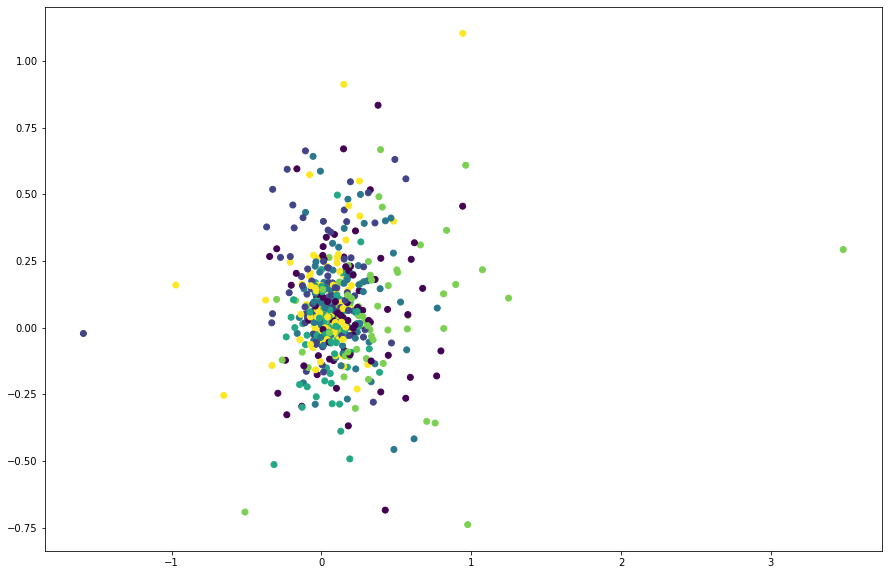

In [36]:
plt.figure(figsize=(15,10))
plt.scatter(x_train[:500,0], x_train[:500,1], c=[ord(a) for a in y_train[:500]])

# 3. Kmeans Clustering

Since we have a rough idea of how many clusters we would expect (because we already simplified the data) we decided first to try Kmeans clustering with the same number of clusters as we created our own categories.

In [38]:
#from sklearn.preprocessing import StandardScaler
#
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(x_train)

kmeans = KMeans(n_clusters=len(set(simp_map.values())))
predictions = kmeans.fit_predict(x_train)

## 3.1. Initial Analysis

In order to see how good the model works out of the box we want to know how accurate it managed to create these clusters according to our ground truth.

In [40]:
def calculateStatistics(ground_labels, predicted):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
   
    #check all pairs 
    for i in range(len(ground_labels)):
        for j in range(i+1, len(ground_labels)):
            # if they belong to the same cluster in round truth
            if ground_labels[i] == ground_labels[j]:
                # did they also match the same cluster from kmeans?
                if predicted[i] == predicted[j]:
                    TP = TP + 1
                else:
                    FN = FN + 1
            else:
                if predicted[i] == predicted[j]:
                    FP = FP + 1
                else:
                    TN = TN + 1
    return TP, FP, TN, FN

In [42]:
ground_labels = [ord(text[-1])-ord('A') for text in y_train]

In [44]:
TP, FP, TN, FN = calculateStatistics(ground_labels, kmeans.labels_)

In [46]:
print("TP : " + str(TP))
print("TN : " + str(TN))
print("FP : " + str(FP))
print("FN : " + str(FN)) # er zijn heel veel TN, dit is logisch want statistisch gezien bij gelijke data zijn er maar 1 op 6 paren die in dezelfde cluster belanden, en waarschijnlijk ook na kmeans
print("right: " + str(TP + TN))
print("wrong: " + str(FN + FP))
print("ratio: " + str((TP + TN)/(FN + FP + TP + TN))) # heel erg skewed door de TN
# verhogen van aantal clusters zorgt voor net nog meer FN's

TP : 1507876
FN : 10648942
FP : 5877154
FN : 1807878
right: 12156818
wrong: 7685032
ratio: 0.6126857122697732


In [48]:
print("precision over all clusters: " + str(TP/(TP + FP)))
print("recall over all clusters: " + str(TP/(TP + FN)))

precision over all clusters: 0.2041800778060482
recall over all clusters: 0.45476111919038625


Changing nothing we get an accuracy of about 30%. Considering the fact a random classifier with 6 classes has 16,6% accuracy (the perfect one 100%) we are at least doing better than random. But we don't consider 30% as sufficient so we asked ourselves why this could be? The main reasons we decided to explore further were:

- our arbitrary number of categories was wrong, the machine could possibly be right
- a general lack of hyperparameter tuning

When we look at a sample we don't even see indications of clusters:

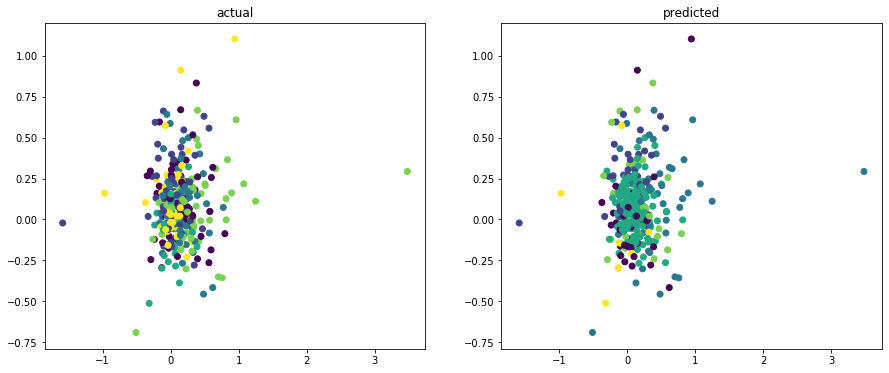

In [50]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(1,2,2)
ax1.set_title('predicted')
ax1.scatter(x_train[:400,0], x_train[:400,1], c=predictions[:400])

ax2 = fig.add_subplot(1,2,1)
ax2.set_title('actual')
ax2.scatter(x_train[:400,0], x_train[:400,1], c=[ord(a) - ord('A') for a in y_train[:400]])

## 3.2. Determing K

First, we examine if we indeed made a mistake and the model was actually right. We did so by using silhouette analysis.

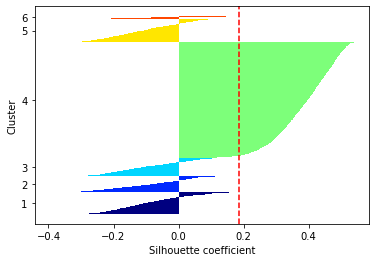

In [52]:
km = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=1e-04,random_state=0)
y_km = km.fit_predict(x_train)

import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(x_train, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
  c_silhouette_vals = silhouette_vals[y_km == c]
  c_silhouette_vals.sort()
  y_ax_upper += len(c_silhouette_vals)
  color = cm.jet(float(i) / n_clusters)
  plt.barh(range(y_ax_lower, y_ax_upper),
           c_silhouette_vals,
           height=1.0,
           edgecolor='none',
           color=color)
  yticks.append((y_ax_lower + y_ax_upper) / 2.)
  y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

Silouhette analysis shows us that it actually does a fairly descent job. And elbow analysis seems to indicate that 6 categories is acutally a valid distinction.

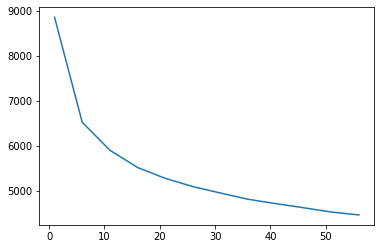

In [54]:
oplossingen = []
for i in range(1,60,5):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(x_train)
    oplossingen.append(kmeans.inertia_)
plt.plot(range(1,60,5),oplossingen)

The elbow method did not give us a definitive answer as to why our precision is only 30%. This made us believe that de data is simply not suited for the Kmeans algorithm. Perhaps because it assumes spherical shapes for the clusters. That is why we decided to try DBScan clustering.

## 4. DBScan Clustering

Looking at the images where ground truths are shown we see that the clusters are not curcilar, however kmeans expects this. That is why we decided to try DBScan aswell.

In [56]:
db = DBSCAN(eps=1.5, min_samples=4)
y_db = db.fit_predict(x_train)

## 4.1. Initial Analysis

In order to see how good the model works out of the box we want to know how accurate it managed to create these clusters according to our ground truth.

In [58]:
ground_labels = [ord(text[-1])-ord('A') for text in y_train]
TP, FP, TN, FN = calculateStatistics(ground_labels, db.labels_)
print("TP : " + str(TP))
print("FN : " + str(TN))
print("FP : " + str(FP))
print("FN : " + str(FN)) # er zijn heel veel TN, dit is logisch want statistisch gezien bij gelijke data zijn er maar 1 op 6 paren die in dezelfde cluster belanden, en waarschijnlijk ook na kmeans
print("right: " + str(TP + TN))
print("wrong: " + str(FN + FP))
print("ratio: " + str((TP + TN)/(FN + FP + TP + TN))) # heel erg skewed door de TN
# verhogen van aantal clusters zorgt voor net nog meer FN's
print("precision over all clusters: " + str(TP/(TP + FP)))
print("recall over all clusters: " + str(TP/(TP + FN)))

TP : 3092888
FN : 1133817
FP : 15392279
FN : 222866
right: 4226705
wrong: 15615145
ratio: 0.2130197033038754
precision over all clusters: 0.16731728742293753
recall over all clusters: 0.9327857253583951


A basic implementation groups everything together in one cluster. Here we need some hyperparameter tuning.

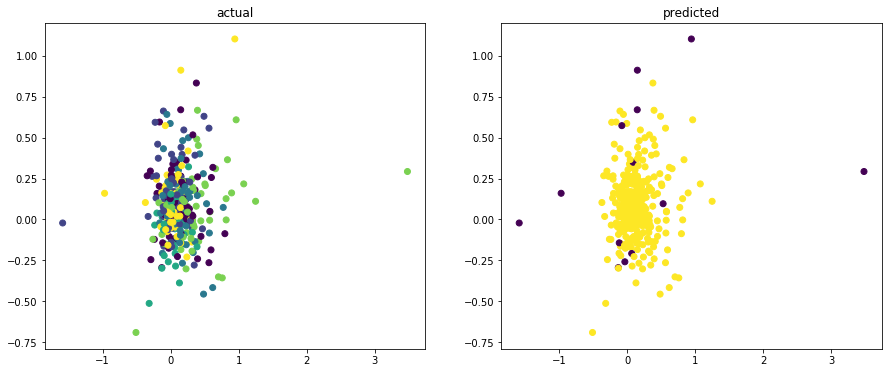

In [60]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(1,2,2)
ax1.set_title('predicted')
ax1.scatter(x_train[:400,0], x_train[:400,1], c=y_db[:400])

ax2 = fig.add_subplot(1,2,1)
ax2.set_title('actual')
ax2.scatter(x_train[:400,0], x_train[:400,1], c=[ord(a) for a in y_train[:400]])

# 5. Doc2Vec + T-SNE + DBScan Hyperparameter tuning

Since this combination (Doc2Vec + T-SNE + DBScan) seemed most promising in theory we tried getting a better performance using pipelines since DBScan has no score for gridSearch.